# Logistic Regression on the Titanic Dataset

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [9]:
train = pd.read_excel('train.xlsx')

In [10]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


## Exploratory Data Analysis

In [11]:
train.isnull().head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,False,False,False,False,False,False,False,False,False,False,True,False
1,False,False,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,True,False
3,False,False,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,True,False


<Axes: >

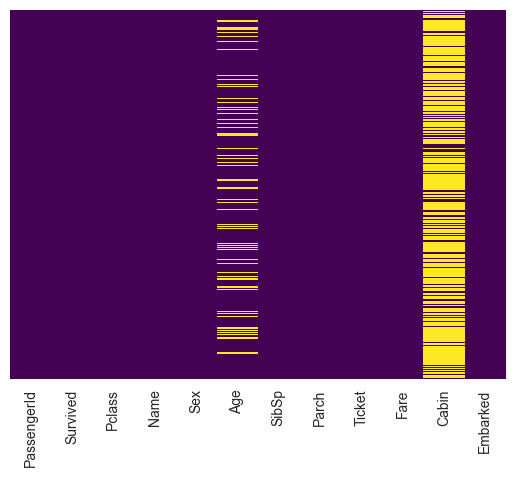

In [12]:
sns.heatmap(train.isnull(),yticklabels=False,cbar=False,cmap='viridis')

If we glimpse at the data, we're missing some age information, we're missing a lot of cabin info and we're missing one row of embarked.
We'll come back to this problem of missing data a little later. But before that lets focus on some exploratory data analysis on a visual level.

In [13]:
sns.set_style('whitegrid')

<Axes: xlabel='Survived', ylabel='count'>

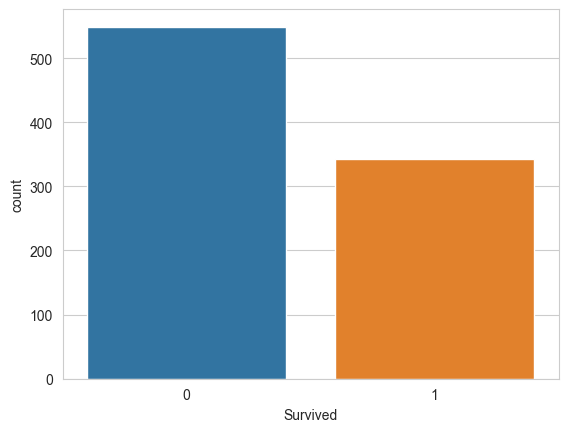

In [14]:
sns.countplot(x='Survived',data=train)

<Axes: xlabel='Survived', ylabel='count'>

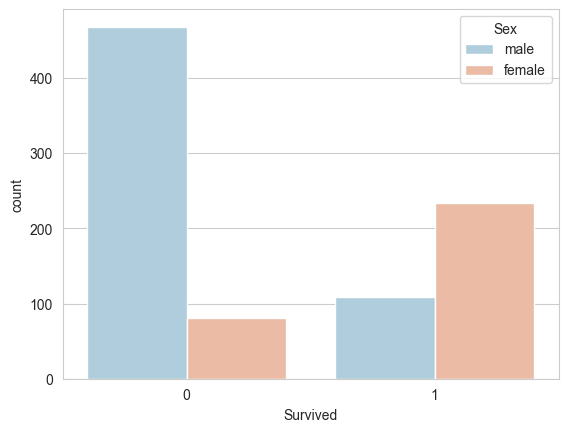

In [15]:
sns.countplot(x='Survived',data=train,hue='Sex',palette='RdBu_r')

Clearly there's a trend here. It looks like people that did not survive were much more likely to be men. While those who survived were twice as likely to be female.

<Axes: xlabel='Survived', ylabel='count'>

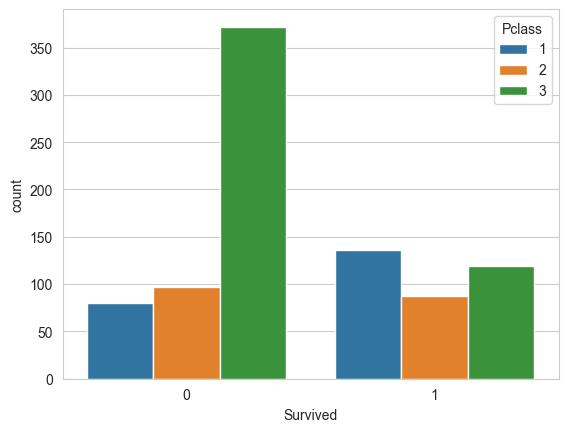

In [16]:
sns.countplot(x='Survived',data=train,hue='Pclass')

Also it looks like the people who did not survive were overwhelmingly part of 3rd class. People that did survive were from the higher classes.

Now lets try and understand the age of the onboard passengers.

<Axes: xlabel='Age', ylabel='Count'>

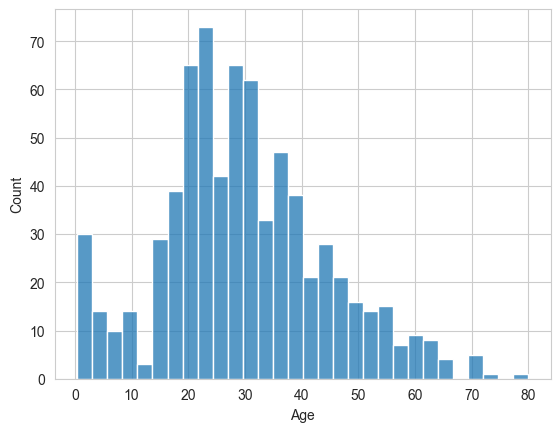

In [17]:
sns.histplot(train['Age'].dropna(),bins=30,kde=False)

There seems to be an interesting bi-modal distribution where there are quite a few young passengers between age 0 and 10. Then the average age tends to be around 20-30.

<Axes: xlabel='SibSp', ylabel='count'>

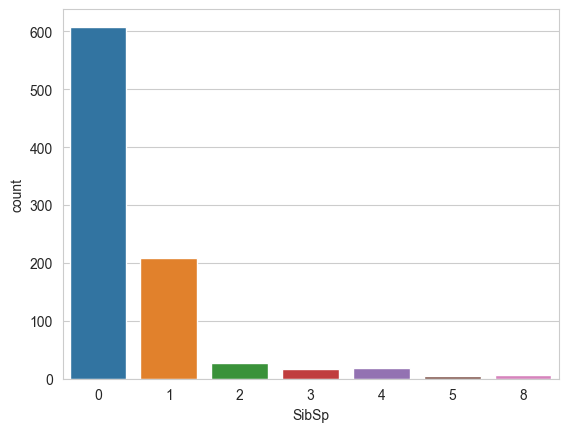

In [18]:
sns.countplot(x='SibSp',data=train)

<Axes: >

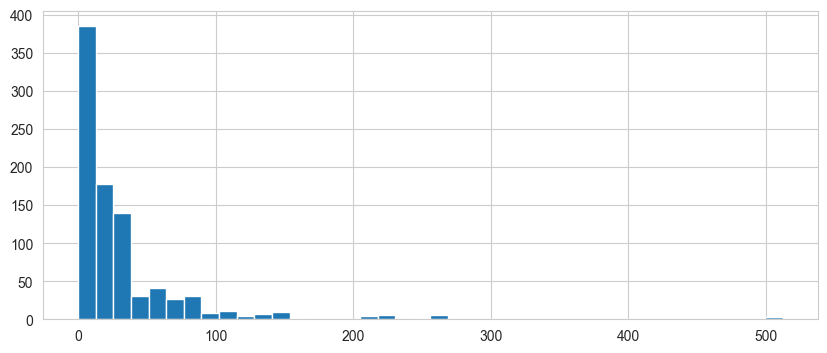

In [19]:
train['Fare'].hist(bins=40,figsize=(10,4))

## Cleaning Data

As we saw earlier there are few columns that are missing some data. We need to clean our dataset before we begin to train our logistic regression model. Lets first try and fill in the missing age values. I'm going to do this by filling in the missing age with the mean age of the passenger class that the passenger belongs to.

<Axes: xlabel='Pclass', ylabel='Age'>

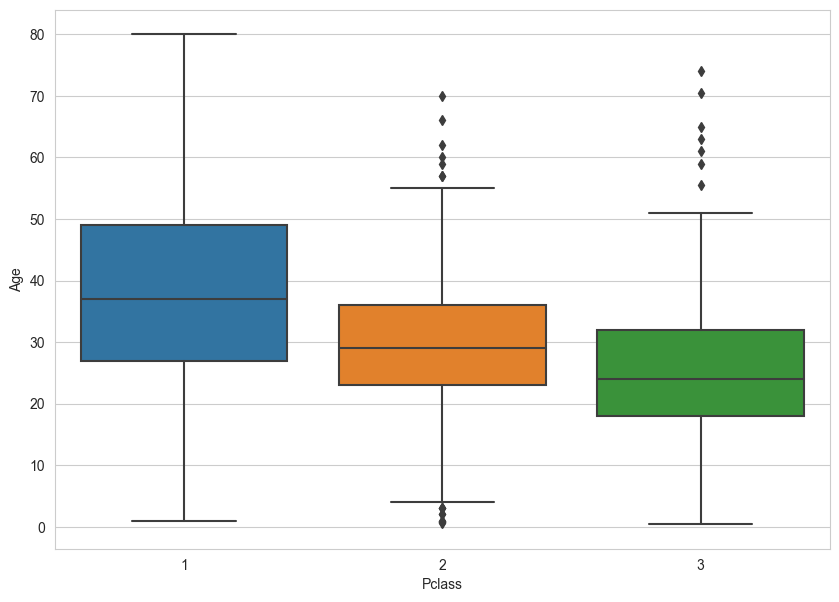

In [20]:
plt.figure(figsize=(10,7))
sns.boxplot(x='Pclass',y='Age',data=train)

In [27]:
train.groupby('Pclass').mean('Age').round()

,PassengerId,Survived,Age,SibSp,Parch,Fare
Pclass,,,,,,
1,462.0,1.0,38.0,0.0,0.0,84.0
2,446.0,0.0,30.0,0.0,0.0,21.0
3,439.0,0.0,25.0,1.0,0.0,14.0


In [30]:
mean_class1 = train.groupby('Pclass').mean('Age').round().loc[1]
mean_class2 = train.groupby('Pclass').mean('Age').round().loc[2]
mean_class3 = train.groupby('Pclass').mean('Age').round().loc[3]

In [33]:
train.loc[train['Pclass']==1,'Age'] = train.loc[train['Pclass']==1,'Age'].fillna(value=mean_class1)
train.loc[train['Pclass']==2,'Age'] = train.loc[train['Pclass']==2,'Age'].fillna(value=mean_class2)
train.loc[train['Pclass']==3,'Age'] = train.loc[train['Pclass']==3,'Age'].fillna(value=mean_class3)

<Axes: >

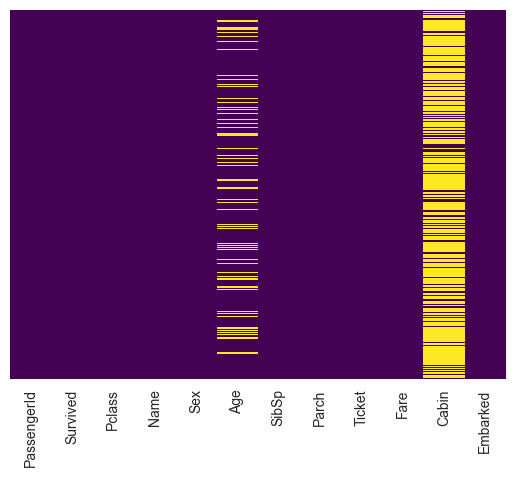

In [34]:
sns.heatmap(train.isnull(),yticklabels=False,cbar=False,cmap='viridis')

I'm going to just drop the cabin column since there's too much missing information.

In [35]:
train.drop('Cabin',axis=1,inplace=True)

In [36]:
train.dropna(inplace=True) # dropping the 1 missing value in Embarked column

I will now convert some of the categorical features in the dataset into dummy variables that our machine learning model can accept.

In [37]:
sex = pd.get_dummies(train['Sex'],drop_first=True)

In [38]:
embark = pd.get_dummies(train['Embarked'],drop_first=True)

In [39]:
train = pd.concat([train,sex,embark],axis=1)

In [40]:
train.head(2)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,male,Q,S
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S,True,False,True
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C,False,False,False


In [41]:
train.drop(['Sex','Embarked','Name','Ticket'],axis=1,inplace=True)

In [42]:
train.drop('PassengerId',axis=1,inplace=True)

In [43]:
train.head()

,Survived,Pclass,Age,SibSp,Parch,Fare,male,Q,S
0,0,3,22.0,1,0,7.2500,True,False,True
1,1,1,38.0,1,0,71.2833,False,False,False
2,1,3,26.0,0,0,7.9250,False,False,True
3,1,1,35.0,1,0,53.1000,False,False,True
4,0,3,35.0,0,0,8.0500,True,False,True


Now lets perform similar data cleaning on the test data.

In [48]:
test = pd.read_excel('test.xlsx')

In [49]:
test.loc[test['Pclass']==1,'Age'] = test.loc[test['Pclass']==1,'Age'].fillna(value=mean_class1)
test.loc[test['Pclass']==2,'Age'] = test.loc[test['Pclass']==2,'Age'].fillna(value=mean_class2)
test.loc[test['Pclass']==3,'Age'] = test.loc[test['Pclass']==3,'Age'].fillna(value=mean_class3)

<Axes: >

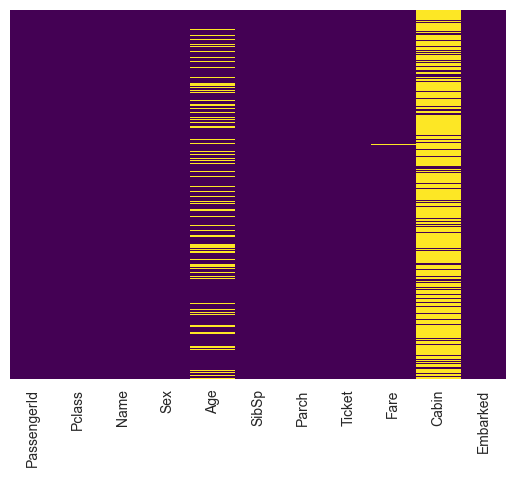

In [50]:
sns.heatmap(test.isnull(),yticklabels=False,cbar=False,cmap='viridis')

In [51]:
test.drop('Cabin',axis=1,inplace=True)

In [52]:
test.dropna(inplace=True)

In [53]:
sex = pd.get_dummies(test['Sex'],drop_first=True)
embark = pd.get_dummies(test['Embarked'],drop_first=True)

In [54]:
test = pd.concat([test,sex,embark],axis=1)

In [55]:
test.drop(['Sex','Embarked','Name','Ticket'],axis=1,inplace=True)

In [56]:
test.head()

,PassengerId,Pclass,Age,SibSp,Parch,Fare,male,Q,S
0,892,3,34.5,0,0,7.8292,True,True,False
1,893,3,47.0,1,0,7.0000,False,False,True
2,894,2,62.0,0,0,9.6875,True,True,False
3,895,3,27.0,0,0,8.6625,True,False,True
4,896,3,22.0,1,1,12.2875,False,False,True


## Train and build Classifier

In [57]:
X = train.drop('Survived',axis=1)
y = train['Survived']

In [62]:
from sklearn.model_selection import train_test_split

In [63]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)

In [64]:
from sklearn.linear_model import LogisticRegression

In [65]:
logmodel = LogisticRegression()
logmodel.fit(X_train,y_train)

C:\Users\hp\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [66]:
logmodel.score(X_train,y_train)

0.8012048192771084

In [67]:
logmodel.score(X_test,y_test)

0.794392523364486

## Making Predictions

In [68]:
test_x = test.drop('PassengerId',axis=1)

In [69]:
predictions = logmodel.predict(test_x)

In [70]:
final_prediction = pd.DataFrame({'PassengerId':test['PassengerId'],'Survived':predictions})

In [71]:
final_prediction.head()

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1
